Most relevant image index: 3


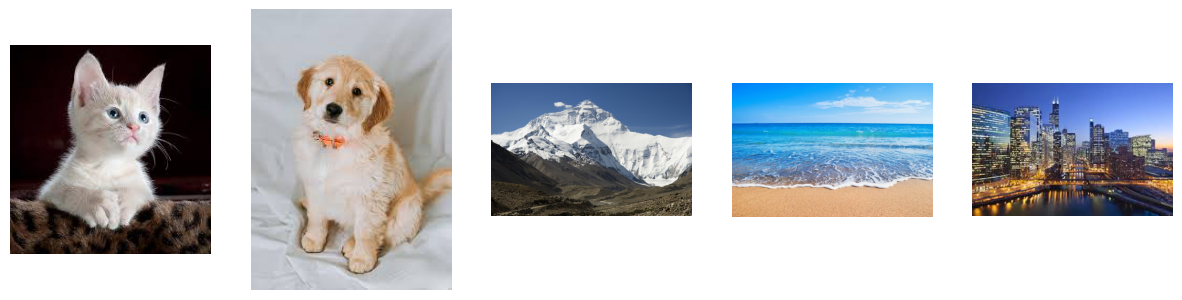

In [45]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Загрузка модели CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Загрузка изображений (пример: локальные пути)
image_paths = [
    "cat.jpeg",
    "dog.jpeg",
    "mountain.jpeg",
    "beach.jpeg",
    "city.jpeg"
]

# Функция для загрузки изображений
def load_images(paths):
    return [Image.open(path) for path in paths]

images = load_images(image_paths)

# Создание эмбеддингов изображений
with torch.no_grad():
    inputs = processor(images=images, return_tensors="pt", padding=True)
    image_features = model.get_image_features(**inputs)

# Описания изображений
descriptions = [
    "A cute cat sitting on a couch",
    "A playful dog running in the park",
    "A beautiful mountain landscape",
    "A sunny beach with waves crashing",
    "A busy city street at night"
]

# Создание эмбеддингов текста
with torch.no_grad():
    text_inputs = processor(text=descriptions, return_tensors="pt", padding=True)
    text_features = model.get_text_features(**text_inputs)

# Функция для поиска наиболее релевантного изображения
def find_most_relevant_image(query, image_features, text_features):
    # Создаем эмбеддинг запроса
    query_inputs = processor(text=[query], return_tensors="pt", padding=True)
    with torch.no_grad():
        query_features = model.get_text_features(**query_inputs)
    
    # Вычисляем косинусное сходство между запросом и изображениями
    similarities = cosine_similarity(query_features.numpy(), image_features.numpy())
    most_relevant_index = np.argmax(similarities)
    return most_relevant_index

# Пример использования
query = "A peaceful natural scene"
most_relevant_index = find_most_relevant_image(query, image_features, text_features)
print(f"Most relevant image index: {most_relevant_index}")

def display_images_with_captions(images):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

# Отображение изображений с описаниями
display_images_with_captions(images)

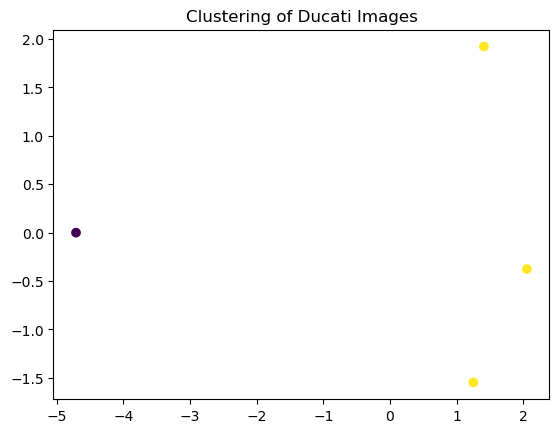

Кластеры показывают, как изображения группируются по схожести.


In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Предположим, что у нас есть список изображений ducati_images
ducati_images = load_images(["ducati1.jpeg", "ducati2.jpeg", "ducati3.jpg", "ducati4.jpg"])

# Создание эмбеддингов для изображений кошек
with torch.no_grad():
    ducati_inputs = processor(images=ducati_images, return_tensors="pt", padding=True)
    ducati_features = model.get_image_features(**ducati_inputs)

# Применяем PCA для снижения размерности до 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(ducati_features.numpy())

# Кластеризация
kmeans = KMeans(n_clusters=2, random_state=0).fit(reduced_features)

# Визуализация
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("Clustering of Ducati Images")
plt.show()

# Выводы
print("Кластеры показывают, как изображения группируются по схожести.")

Caption for image 1: a red motorcycle on a white background
Caption for image 2: a red motorcycle is shown in the image
Caption for image 3: the duc duc motor concept motorcycle
Caption for image 4: the duc duc project is a motorcycle that is designed to be a duc duc duc project duc duc project




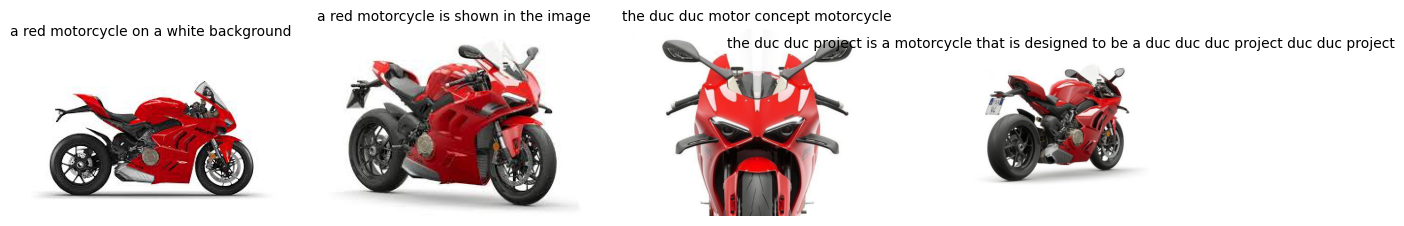

In [37]:
from transformers import BlipProcessor, BlipForConditionalGeneration

# Загрузка модели BLIP
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Функция для генерации описаний
def generate_caption(image):
    inputs = blip_processor(image, return_tensors="pt")
    out = blip_model.generate(**inputs)
    return blip_processor.decode(out[0], skip_special_tokens=True)

# Пример использования
captions = [generate_caption(img) for img in ducati_images]
for i, caption in enumerate(captions):
    print(f"Caption for image {i+1}: {caption}")
print('\n')
# Функция для отображения изображений с описаниями
def display_images_with_captions(images, captions):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(captions[i], fontsize=10)
    plt.show()

# Отображение изображений с описаниями
display_images_with_captions(ducati_images, captions)

In [21]:
from transformers import BlipProcessor, BlipForConditionalGeneration

# Загрузка модели BLIP
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Функция для генерации описаний с использованием BLIP
def generate_blip_captions(images):
    captions = []
    for img in images:
        inputs = blip_processor(img, return_tensors="pt")
        out = blip_model.generate(**inputs)
        captions.append(blip_processor.decode(out[0], skip_special_tokens=True))
    return captions

# Функция для сравнения моделей
def compare_models(images, descriptions):
    # CLIP: поиск наиболее релевантного изображения
    with torch.no_grad():
        inputs = processor(images=images, return_tensors="pt", padding=True)
        image_features = model.get_image_features(**inputs)
        text_inputs = processor(text=descriptions, return_tensors="pt", padding=True)
        text_features = model.get_text_features(**text_inputs)
    
    similarities = cosine_similarity(text_features.numpy(), image_features.numpy())
    clip_results = np.argmax(similarities, axis=1)
    
    # BLIP: генерация описаний
    blip_captions = generate_blip_captions(images)
    
    # Вывод результатов
    print("CLIP Results:")
    for i, desc in enumerate(descriptions):
        print(f"Description: {desc} -> Most relevant image: {clip_results[i]}")
    
    print("\nBLIP Results:")
    for i, caption in enumerate(blip_captions):
        print(f"Image {i+1}: {caption}")

# Сравнение моделей
compare_models(images, descriptions)

CLIP Results:
Description: A cute cat sitting on a couch -> Most relevant image: 0
Description: A playful dog running in the park -> Most relevant image: 1
Description: A beautiful mountain landscape -> Most relevant image: 2
Description: A sunny beach with waves crashing -> Most relevant image: 3
Description: A busy city street at night -> Most relevant image: 4

BLIP Results:
Image 1: a white kitten sitting on a brown blanket
Image 2: a small dog sitting on a white sheet
Image 3: a mountain range with a snow covered peak
Image 4: a beach with waves crashing on the sand
Image 5: the city skyline at night
